# COMP5318 - Machine Learning and Data Mining: Assignment 1


### NOTE: PLEASE GO THROUGH APPENDIX OF REPORT FOR DETAILED CODE RUNNING INSTRUCTIONS.

# INTRODUCTION
The goal of this assignment is to build a classifier to classify some grayscale images of the size **28x28** into **10** different mentioned classes. **PCA** is used as a pre-processing technique to reduce the amount of computation as the dimension of original data is large.<br /> **Four** different classifiers including **Neural Network, K- Nearest Neighbour, Logistic Regresssion and Naive Bayes** have been used in order toachieve the goal and draw comparison based on acurracy and computing time.

## Dataset description
The provided dataset consists of a training set of 30,000 samples and a test set of 5,000 samples. They belong to 10 different categories/classes. The labels of the first 2,000 test examples were given, so the performance of our proposed methods are analyzed by exploiting the 2,000 labelled test samples.The rest 8,000 labels of the test set are reserved.<br /> **NONE of the samples from testing set were used for training.** <br />


## Class Labels for provided dataset:<br />
0 T-shirt/Top<br />
1 Trouser<br />
2 Pullover<br />
3 Dress<br />
4 Coat<br />
5 Sandal<br />
6 Shirt<br />
7 Sneaker<br />
8 Bag<br />
9 Ankle boot <br />

### How to load the data
There is a data folder with 4 main files (which can be downloaded from Canvas):

    1. images_training.h5
    2. labels_training.h5
    3. images_testing.h5
    4. labels_testing_2000.h5

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import os
import time

Then **training data** is a numpy array of the shape (30000, 784), and **training label** is a numpy array of the shape (30000, ).<br />
The **testing data** is a numpy array of shape (10000,784) and **testing label** is a numpy array of shape (2000, ). Thus, we have sliced aur **training data** to (2000, 784)

To read the hdf5 file and load the data into a numpy array, assuming the **training and testing data files are uploaded in the current folder of G-drive** . <br /> Use the following code:

In [2]:
with h5py.File('./Input/train/images_training.h5','r') as H:
    data_train = np.copy(H['datatrain'])
with h5py.File('./Input/train/labels_training.h5','r') as H:
    label_train = np.copy(H['labeltrain'])
with h5py.File('./Input/test/images_testing.h5','r') as H:
    data_test = np.copy(H['datatest'])
with h5py.File('./Input/test/labels_testing_2000.h5','r') as H:
    label_test = np.copy(H['labeltest'])


# using H['datatest'], H['labeltest'] for test dataset.

m_train=30000
X_train= data_train
y_train= label_train
X_test= data_test[0:2000]
y_test= label_test
print(data_test.shape)

(5000, 784)


Showing a sample data belonging to it's corresponding **Class**:

(30000, 28, 28)


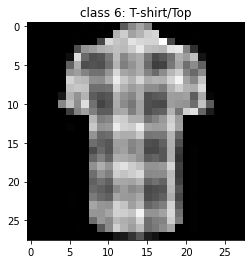

In [3]:
import matplotlib.pyplot as plt
X_train = X_train.reshape((X_train.shape[0], 28, 28))
print(X_train.shape)
plt.imshow(X_train[0], cmap=plt.get_cmap('gray'))
plt.title("class " + str(y_train[0]) + ": T-shirt/Top" )
plt.show()

Executing **Hot Label Encoding** just for test labels:

In [4]:
one_hot_labels = np.zeros((30000, 10))

for i in range(30000):
    one_hot_labels[i, label_train[i]] = 1

print(one_hot_labels)

[[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]


Reshaping training data back to original.

In [5]:
X_train = X_train.reshape(m_train, -1)

## 'Part A' :Pre-Processing Technique used:


In [6]:
features = data_train.T
covariance_matrix = np.cov(features)

eig_value, eig_vector = np.linalg.eig(covariance_matrix)

print('Total No. of eigen values ')
print(eig_value.shape)
print('\n')

sum(eig_value[0:350])/sum(eig_value)
len(eig_value)
eig_pairs = [(np.abs(eig_value[i]), eig_vector[:,i]) for i in range(len(eig_value))]

#Eigenvalues in descending order
eig_pairs.sort()
eig_pairs.reverse()


#Complete hstack of 350 features having more weightage:
matrix_w=eig_pairs[0][1].reshape(784,1)
for i in range(1,350):
  a = eig_pairs[i][1].reshape(784,1)
  matrix_w = np.hstack((matrix_w, a))
  

data_train_pca = data_train.dot(matrix_w)

data_test_pca = data_test.dot(matrix_w)


print('Size of new Projection matrix post PCA:')
print(matrix_w.shape)
print('\n')
print('Size of new data_train_PCA matrix:')
print(data_train_pca.shape)
print('\n')
print('Size of new data_test_PCA matrix:')
print(data_test_pca.shape)

data_train = data_train_pca
data_test = data_test_pca
X_train= data_train
y_train= label_train
X_test= data_test[0:2000]
y_test= label_test

Total No. of eigen values 
(784,)


Size of new Projection matrix post PCA:
(784, 350)


Size of new data_train_PCA matrix:
(30000, 350)


Size of new data_test_PCA matrix:
(5000, 350)


## 'Part B' :Classifiers Used:


## 1.Neural Network

In [7]:
def softmax(x):
    x = x - np.max(x)
    fin = (np.exp(x).T / np.sum(np.exp(x),axis=1))
    return fin
    
def calc_cost(x, y):
    return np.squeeze(- np.sum(np.multiply(np.log(x), y))/y.shape[1])

def fwd_propogation(X_train, W1, W2, b1, b2):
    if W1.shape[1] != X_train.shape[0]:
      X_train=X_train.T
    Z_one = np.dot(W1, X_train) + b1
    A_one = np.tanh(Z_one)
    Z_two = np.dot(W2, A_one) + b2
    A_two = softmax(Z_two.T)

    return {"Z_one": Z_one,
            "A_one": A_one,
            "Z_two": Z_two,
            "A_two": A_two}

def back_propogation(W1, W2, zaza, X_train, y_train):
    n = y_train.shape[1]
    A_one = zaza['A_one']
    A_two = zaza['A_two']

    d_Z2 = A_two - y_train
    d_W2 = (1 / n) * np.dot(d_Z2, A_one.T)
    d_b2 = (1 / n) * np.sum(d_Z2, axis=1, keepdims=True)

    d_Z1 = np.multiply(np.dot(W2.T, d_Z2), 1 - np.square(A_one))
    d_W1 = (1 / n) * np.dot(d_Z1, X_train.T)
    d_b1 = (1 / n) * np.sum(d_Z1, axis=1, keepdims=True)

    return {"d_W1": d_W1,
            "d_b1": d_b1,
            "d_W2": d_W2,
            "d_b2": d_b2}

def update_parameters(W1, W2, b1, b2, grad, learning_rate):
    W1 = W1 - learning_rate * grad['d_W1']
    b1 = b1 - learning_rate * grad['d_b1']
    W2 = W2 - learning_rate * grad['d_W2']
    b2 = b2 - learning_rate * grad['d_b2']

    return W1, W2, b1, b2

def nn_predict(W1, W2, b1, b2, X_train):
    zaza = fwd_propogation(X_train, W1, W2, b1, b2)
    prediction = np.argmax(zaza['A_two'], axis=0)
    return prediction

def neuralnet(X_train, y_train,Y_real,x_test,y_test, label_test, sizeof_h, epochs, learning_rate):
    np.random.seed(42)
    sizeof_x=X_train.shape[0]
    sizeof_y=y_train.shape[0]
    
    # layers
    W1 = np.random.randn(sizeof_h, sizeof_x) * 0.01
    b1 = np.random.rand(sizeof_h, 1)
    W2 = np.random.rand(sizeof_y, sizeof_h)
    b2 = np.random.rand(sizeof_y, 1)
    

    nn_costs = []
    i=0
    while i in range(epochs):

        zaza = fwd_propogation(X_train, W1, W2, b1, b2)

        nn_cost = calc_cost(zaza['A_two'], y_train)
        grad = back_propogation(W1, W2, zaza, X_train, y_train)
        if (i > 1500):
            learning_rate1 = 0.95*learning_rate
            W1, W2, b1, b2 = update_parameters(W1, W2, b1, b2, grad, learning_rate1)
        else:
            W1, W2, b1, b2 = update_parameters(W1, W2, b1, b2, grad, learning_rate)

        if i % 50 == 0:
            nn_costs.append(nn_cost)
            print("Cost after %i iteration(s): %f" % (i, nn_cost))

        i = i + 1


    prediction = nn_predict(W1, W2, b1, b2, X_train)
    print("Train accuracy: {} %", sum(prediction == Y_real) / (float(len(Y_real))) * 100)
    prediction=nn_predict(W1, W2, b1, b2, X_test)
    print("Test accuracy: {} %", sum(prediction == y_test) / (float(len(y_test))) * 100)
    output= nn_predict(W1, W2, b1, b2, data_test)


    plt.plot(nn_costs)
    plt.ylabel('cost')
    plt.xlabel('epochs (x100)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

    return output

## 2.LOGISTIC REGRESSION

In [8]:
# calculating the gradient 
def lr_softmax(Z): # TODO
    e_Z = np.exp(Z)
    A = e_Z / e_Z.sum(axis = 1, keepdims = True)
    return A

def grad_softmax(X, y, W):
    temp = lr_softmax(X.dot(W))
    sizeof_x=X.shape[0]    
    n = range(sizeof_x)  
    temp[n, y] = temp[n, y] - 1           
    return X.T.dot(temp)/sizeof_x

def loss_softmax(X, y, W):
    A = lr_softmax(X.dot(W))
    id0 = range(X.shape[0])
    return -np.mean(np.log(A[id0, y]))

# predictions
def pred(W, X):
    return np.argmax(lr_softmax(X.dot(W)), axis = 1)

# calculating accuracy
def accuracy(predictions,y):
    return sum(predictions == y)/float(len(y))

# classifier function
def classifier_logistic(X, y, W, learning_rate = 0.05, epochs = 1000, tot = 1e-5, batch_size = 50):
    W_original = W.copy()
    epoch = 0 
    costs = [loss_softmax(X, y, W)]
    tot_batches = int(np.ceil(float(X.shape[0])/batch_size))
    while epoch in range(epochs): 
        epoch = epoch + 1 
        ids_mix = np.random.permutation(X.shape[0]) 
        for i in range(tot_batches):
            ids_batch = ids_mix[batch_size*i:min(batch_size*(i+1), X.shape[0])] 
            batch_X = X[ids_batch]
            batch_y = y[ids_batch]
            W = W - learning_rate*grad_softmax(batch_X, batch_y, W)
        cost = loss_softmax(X, y, W)
        costs.append(cost)
        
        if epoch%50 == 0:
            print("Cost after %i iteration(s): %f" % (epoch, cost))

        if np.linalg.norm(W - W_original)/W.size < tot:
            break 
        
        W_original = W.copy()

    predictions = pred(W,X_train)
    print("% Accuracy of model on train set:",accuracy(predictions,y_train)*100)

    predictions = pred(W,X_test)
    print("% Accuracy of model on test set:",accuracy(predictions,y_test)*100)
    
    output = pred(W,data_test)

    plt.plot(costs)
    plt.xlabel('number of epoches', fontsize = 12)
    plt.ylabel('loss', fontsize = 12)
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.show()


    return output 


## 3.KNN CLASSIFIER

In [9]:
class knn_funct():
    "A KNN with L2 dist"

    def __init__(self):
        pass

    def train_funct(self, X, y):
        self.data_train = X
        self.label_train = y

    def compute_distance(self, X):
        num_test = X.shape[0]
        num_train = self.data_train.shape[0]

        dot_pro = np.dot(X, self.data_train.T)
        sum_square_test = np.square(X).sum(axis = 1)
        sum_square_train = np.square(self.data_train).sum(axis = 1)
        
        distance = np.sqrt(-2 * dot_pro + sum_square_train + np.matrix(sum_square_test).T)

        return(distance)
      
    def predict_funct(self, X, k):
        distance = self.compute_distance(X)

        num_test = distance.shape[0]
        y_predicted = np.zeros(num_test)

        for i in range(num_test):
            k_closest_y = []
            labels = self.label_train[np.argsort(distance[i,:])].flatten()
            # find k nearest lables
            k_closest_y = labels[:k]

            c = Counter(k_closest_y)
            y_predicted[i] = c.most_common(1)[0][0]

        return(y_predicted)
      
def knn_accuracy(y_pre,y):
    count = y_pre == y
    accuracy = count.sum()/len(count)
    return accuracy

def knn_predict(data_test, batch_size):
  predictions = []

  for i in range(int(len(data_test)/(2*batch_size))):
      # predicts from i * batch_size to (i+1) * batch_size
      predts = classifier.predict_funct(data_test[i * batch_size:(i+1) * batch_size], k)
      predictions = predictions + list(predts)
  
    # To predict second half of test data

  for i in range(int(len(data_test)/(2*batch_size)), int(len(data_test)/batch_size)):
      #predicts from i * batch_size to (i+1) * batch_size
      predts = classifier.predict_funct(data_test[i * batch_size:(i+1) * batch_size], k)
      predictions = predictions + list(predts)


  y_new = np.asarray(predictions)
  return y_new      

## 4.NAIVE BAYES

In [10]:
class Naive_Bayes(object):
    def __init__(self, learning_rate= 0.001):
        self.learning_rate = learning_rate 

    def nb_train(self, X, y):
        sample_count = X.shape[0]
        sep = [[x for x, p in zip(X, y) if p == n] for n in np.unique(y)]
        self.log_prior_class = [np.log(len(i) / sample_count) for i in sep]
        count_arr = np.array([np.array(i).sum(axis=0) for i in sep]) + self.learning_rate
        self.log_prob_feature = np.log(count_arr / count_arr.sum(axis=1)[np.newaxis].T)
        return self

    def nb_predict(self, X): # applying log-likelihood notation
        return [(self.log_prob_feature * a).sum(axis=1) + self.log_prior_class for a in X]

    def predict_nb(self, X):
        return np.argmax(self.nb_predict(X), axis=1)

## 'Part C': CHOOSING AND RUNNING MODELS:


.

*   Options 1,2,3 have almost same accuracy.
*   KNN(**option 3**) is recommended based on computing time and a bit more accuracy



In [11]:
print("Enter either 1, 2, 3 or 4 as your choice:")
print("1. Neural Network Classifier")
print("2. Logistic Regression Classifier")
print("3. K Nearest Neighbour Classifier")
print("4. Naive Bayes Classifier")
print()
user_input=int(input("enter choice: "))
tic=time.time()
if user_input is 1:
  Y = y_train
  y_train = (np.arange(np.max(Y) + 1) == Y[:, None]).astype(int)
  output=neuralnet(X_train.T, y_train.T, Y, X_test.T, y_test.T, label_test, sizeof_h=100, epochs=1500,
                                  learning_rate=0.01)
elif user_input is 2:
  W = np.random.randn(X_train.shape[1], 10)
  output = classifier_logistic(X_train, y_train, W, batch_size = 50, epochs = 1200, learning_rate = 0.05)

elif user_input is 3:
  batch_size = 1000
  # k = 4 is chosen over K=1 due to risk of overfitting.
  k = 4
  classifier = knn_funct()
  classifier.train_funct(X_train, y_train)
  predictions=knn_predict(X_train,batch_size)
  print("% Accuracy of model on train set:",knn_accuracy(predictions,y_train)*100)
  predictions=knn_predict(X_test,batch_size)
  print("% Accuracy of model on test set:",knn_accuracy(predictions,y_test)*100)
  output = knn_predict(data_test,batch_size)

elif user_input is 4:
  model = Naive_Bayes()
  model.nb_train(X_train,y_train)
  predictions = model.predict_nb(X_train)
  print("% Accuracy of model on training set:",accuracy(predictions,y_train)*100)
  predictions = model.predict_nb(X_test)
  print("% Accuracy of model on test set:",accuracy(predictions,y_test)*100)
  output = model.predict_nb(data_test)
toc=time.time()

print()
print("Total time taken (min): " + str((toc-tic)/60) )

<>:9: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:14: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:18: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:30: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:9: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:14: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:18: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:30: SyntaxWarning: "is" with a literal. Did you mean "=="?


Enter either 1, 2, 3 or 4 as your choice:
1. Neural Network Classifier
2. Logistic Regression Classifier
3. K Nearest Neighbour Classifier
4. Naive Bayes Classifier

enter choice: 4


<ipython-input-11-3ae11c67df73>:9: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if user_input is 1:
<ipython-input-11-3ae11c67df73>:14: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif user_input is 2:
<ipython-input-11-3ae11c67df73>:18: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif user_input is 3:
<ipython-input-11-3ae11c67df73>:30: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif user_input is 4:
<ipython-input-10-e73cd5550223>:10: RuntimeWarning: invalid value encountered in log
  self.log_prob_feature = np.log(count_arr / count_arr.sum(axis=1)[np.newaxis].T)


% Accuracy of model on training set: 10.136666666666667
% Accuracy of model on test set: 9.6

Total time taken (min): 0.006969710191090901


### 'Part D': OUTPUT FILE FOR PREDICTIONS

In [0]:
import numpy as np
# assume output is the predicted labels
# (5000,) 
with h5py.File('predicted_labels.h5','w') as H:
  H.create_dataset('output',data=output)

print(output.shape)